In [2]:
!pip install keras
!pip install tensorflow-gpu==2.2

In [ ]:
!conda install pydot
!conda install pydotplus
!conda install -c conda-forge python-graphviz


| Collecting package metadata (current_repodata.json): done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    pydotplus-2.0.2            |             py_1          22 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-py_1

The following packages will be UPDATED:

  openssl                                 1.1.1g-h516909a_0 -->

In [9]:
import sys
import numpy as np
import pandas as pd
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt

import keras

import cv2
import time
from keras.optimizers import SGD

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate,Conv1D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

from keras.layers import Dropout, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Cropping2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalMaxPooling1D

from keras.models import load_model

In [10]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
def get_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
# #################################
    input_shape=(400, 225, 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    x1 =  concatenate([left_input, right_input])
    
    # Step 1 - Convolution
    x1= Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x1)
    x1= BatchNormalization()(x1)
    x1= MaxPooling2D(pool_size = (2, 2))(x1)
    x1= Dropout(0.2)(x1)
    # Adding a second convolutional layer
    x1= Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x1)
    x1= BatchNormalization()(x1)
    x1= MaxPooling2D(pool_size = (2, 2))(x1)
    x1= Dropout(0.2)(x1)
    # Adding a third convolutional layer
    x1= Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x1)
    x1= BatchNormalization()(x1)
    x1= MaxPooling2D(pool_size = (2, 2))(x1)
    x1= Dropout(0.2)(x1)
    # Adding a fourth convolutional layer
    x1= Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x1)
    x1= BatchNormalization()(x1)
    x1= MaxPooling2D(pool_size = (2, 2))(x1)
    x1= Dropout(0.2)(x1)
    x1= GlobalMaxPooling2D()(x1)
    x1= Dense(128, activation='relu', kernel_initializer='he_uniform')(x1)
    x1= Dropout(0.5)(x1)



    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction =  Dense(1,activation='sigmoid')(x1)
    
    # Connect the inputs with the outputs
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    
    keras.utils.plot_model(model, "two_inputs_high_concatenate.png", show_shapes=True)
    # return the model
    return model

In [12]:
model = get_model((400, 225, 3))
model.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 225, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 400, 225, 3) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 400, 225, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d

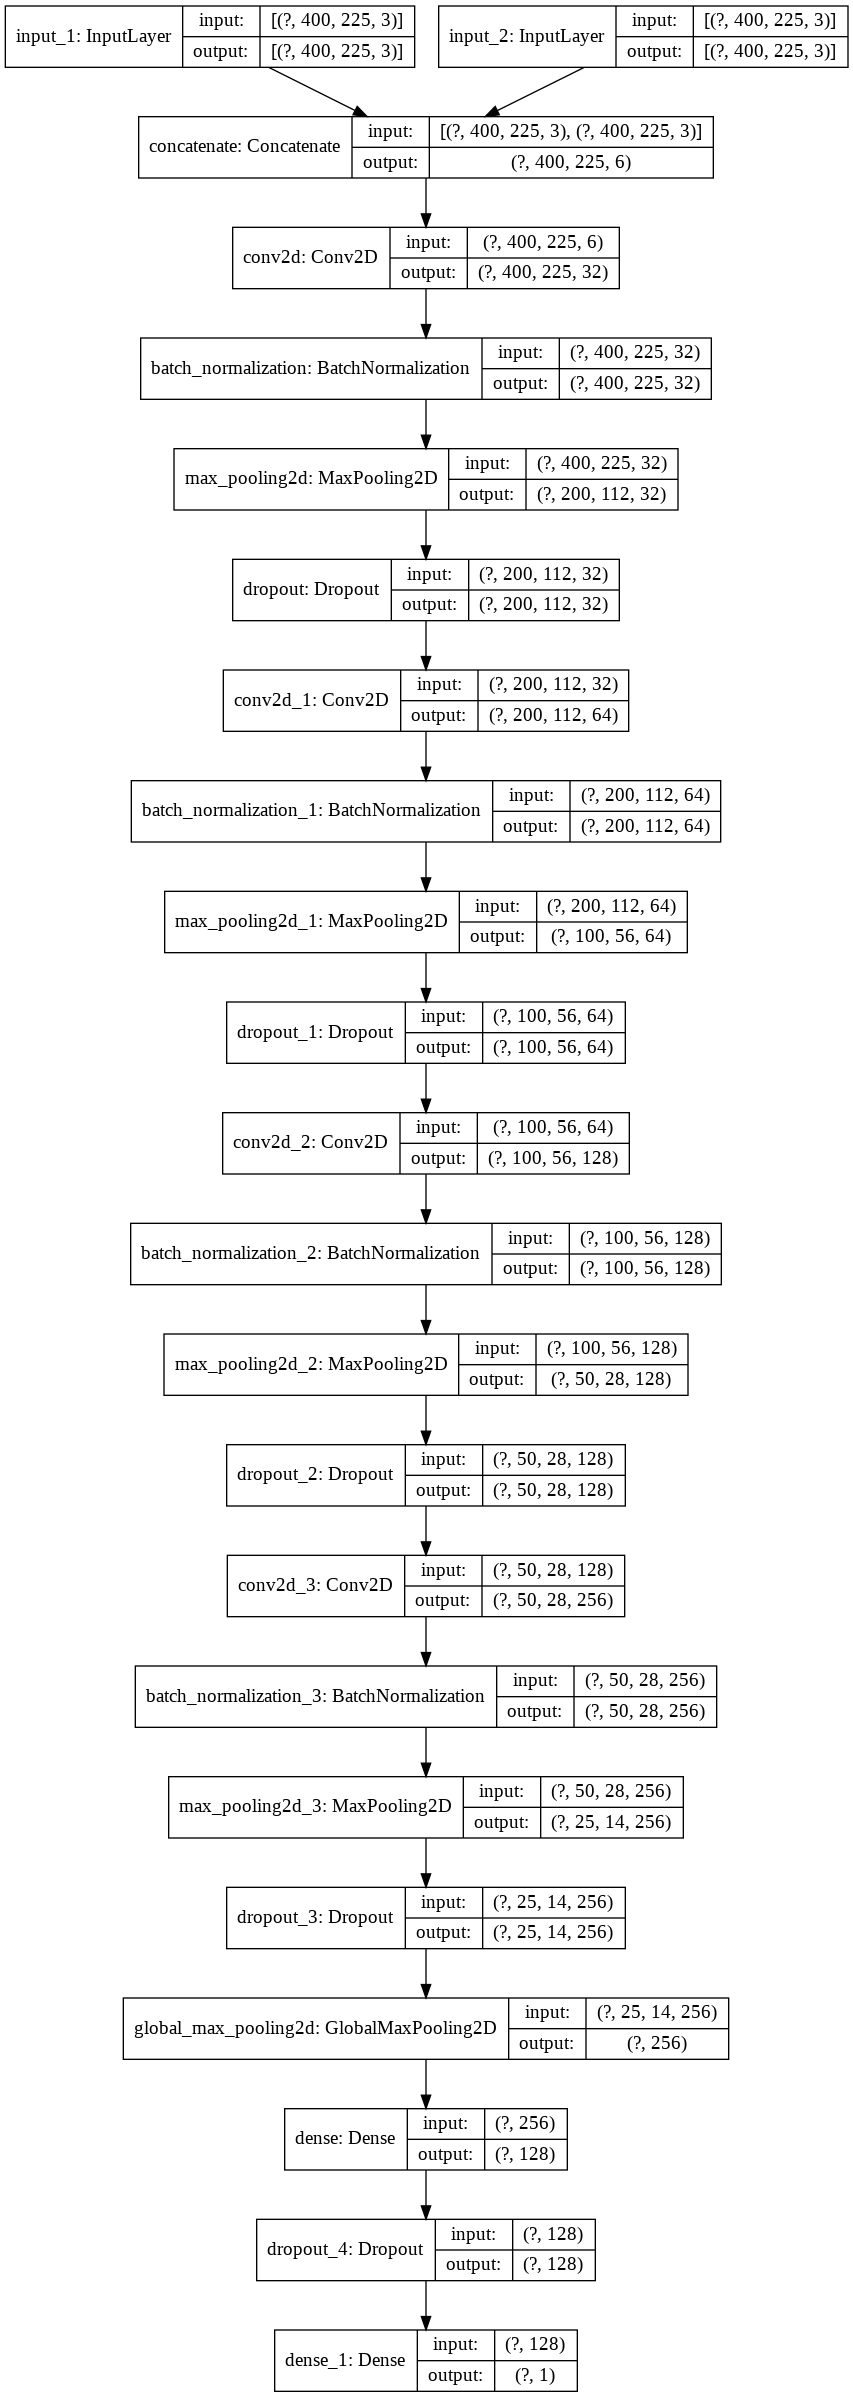

In [13]:
from IPython.display import Image
Image(retina=True, filename='two_inputs_high_concatenate.png')

In [14]:
model=load_model("weights_imported/two_inputs_high_concatenate-v1-epoch31.h5")


In [15]:
opt = SGD(lr=0.001, momentum=0.9)
# model.compile(loss="binary_crossentropy",optimizer=opt,metrics = ['accuracy'])

model.compile(loss="binary_crossentropy",optimizer=opt,metrics =[tf.keras.metrics.AUC()])

In [16]:
batch_size=32


train_datagen = ImageDataGenerator(
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   vertical_flip = True,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(                                 )

training_set = train_datagen.flow_from_directory('data/Florida/day1_full/train/',
                                                 target_size = (400, 225),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')


# test_set = test_datagen.flow_from_directory('data/Florida/day1_full/test/',
#                                             target_size = (400, 225),
#                                             batch_size = batch_size,
#                                             class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/Florida/test_3096/',
                                            target_size = (400, 225),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
img_height = 225
img_width = 400
dir1= 'data/Florida/day1_full/train/'
# dir2= 'data/Florida/day1_full/test/'
dir2= 'data/Florida/test_3096/'

# dir3= 'data/Florida/day1_full/test/'
# dir4= 'data/Florida/day1_full/test/'

input_imgen = ImageDataGenerator(#rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   rotation_range=5.,
                                   horizontal_flip = True)

test_imgen = ImageDataGenerator(#rescale = 1./255
                               )


def generate_generator_multiple(generator,dir1, dir2, batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'binary',
                                          batch_size = batch_size
                                         )
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (img_height,img_width),
                                          class_mode = 'binary',
                                          batch_size = batch_size
                                         )
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
            
inputgenerator=generate_generator_multiple(generator=input_imgen,
                                           dir1=dir1,
                                           dir2=dir1,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_width)       
     
testgenerator=generate_generator_multiple(test_imgen,
                                          dir1=dir2,
                                          dir2=dir2,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_width)              
steps_per_epoch =round(len(training_set))
validation_steps =round(len(test_set))
# print(steps_per_epoch)
# print(validation_steps)

history=model.fit(inputgenerator,
                        steps_per_epoch=steps_per_epoch,
                        epochs = 2,
                        validation_data = testgenerator,
                        validation_steps = validation_steps,
#                         use_multiprocessing=True,
                        shuffle=False)


Found 32410 images belonging to 2 classes.
Found 3097 images belonging to 2 classes.
Found 32410 images belonging to 2 classes.
Found 32410 images belonging to 2 classes.
Epoch 1/2
1013/1013 [==============================] - ETA: 0s - loss: 0.2758 - auc_1: 0.9515Found 3097 images belonging to 2 classes.
Found 3097 images belonging to 2 classes.
1013/1013 [==============================] - 8977s 9s/step - loss: 0.2758 - auc_1: 0.9515 - val_loss: 0.4580 - val_auc_1: 0.3703
Epoch 2/2
1013/1013 [==============================] - 8926s 9s/step - loss: 0.2774 - auc_1: 0.9506 - val_loss: 0.4690 - val_auc_1: 0.3593


In [ ]:
# #load weights
# classifier = load_model("weights/siamese_4layers_day1_v1.h5")

In [ ]:
#save weights
model.save("weights/two_inputs_high_concatenate-epoch5.h5")